In [92]:
all = [var for var in globals() if var[0] != '_']
for var in all:
    del globals()[var]
del var, all

In [93]:
import os
import numpy as np
import pandas as pd
from mpi4py import MPI
import gmsh

import ufl
from dolfinx import fem, io
from dolfinx.io.gmsh import read_from_msh
import dolfinx_mpc
from dolfinx_mpc import LinearProblem

import pyvista
from dolfinx import plot

In [94]:
msh_path = "mesh_bcc_with_phscgrp.msh"
mesh, cell_tags, facet_tags, physical_groups , *_ = read_from_msh(
    msh_path, MPI.COMM_WORLD, rank=0, gdim=3
)
print(mesh)
print("cell_tags:", cell_tags is not None)
print("facet_tags:", facet_tags is not None)
print("physical_groups:", physical_groups)

Info    : Reading 'mesh_bcc_with_phscgrp.msh'...
Info    : 8 entities
Info    : 7317 nodes
Info    : 28080 elements
Info    : Done reading 'mesh_bcc_with_phscgrp.msh'
cell_tags: True
facet_tags: True
physical_groups: None


In [95]:
print("mesh.topology.dim =", mesh.topology.dim)
print("mesh.geometry.dim =", mesh.geometry.dim)
print("num cells =", mesh.topology.index_map(mesh.topology.dim).size_local)

mesh.topology.dim = 3
mesh.geometry.dim = 3
num cells = 27504


In [96]:
from dolfinx.cpp.mesh import cell_entity_type
print("cell type:", mesh.topology.cell_type)

cell type: CellType.tetrahedron


Unique cell tags: [7]


/tmp/ipykernel_87338/1840513390.py:21: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  pl.show()


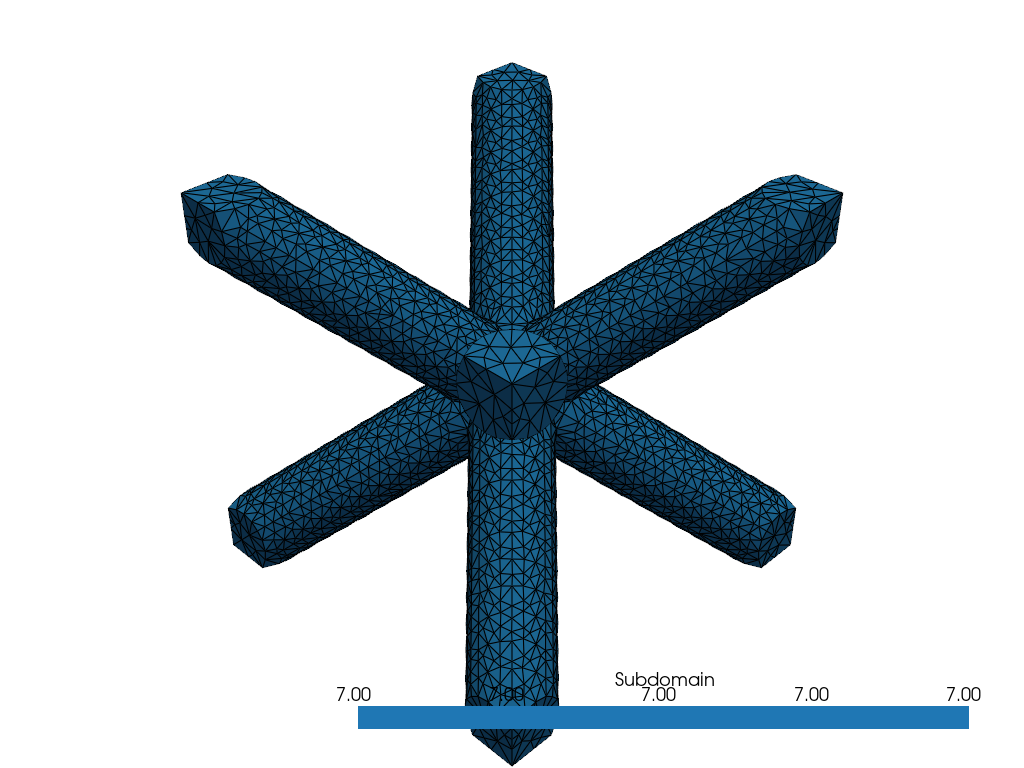

In [97]:
# 로컬 rank에서만 시각화
if MPI.COMM_WORLD.rank == 0:
    topology, cell_types, geometry = plot.vtk_mesh(mesh)
    grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

    grid.cell_data["Subdomain"] = cell_tags.values.astype(np.int32)

    unique_tags = np.unique(grid.cell_data["Subdomain"])
    print("Unique cell tags:", unique_tags)

    pl = pyvista.Plotter(notebook=True)
    pl.add_mesh(
        grid,
        show_edges=True,
        scalars="Subdomain",      # ★ 이거 추가
        cmap="tab20",             # 색 구분 잘 되는 팔레트(원하면 변경)
        categories=True,         # ★ 정수 태그를 범주형으로
        clim=[unique_tags.min(), unique_tags.max()],
        scalar_bar_args={"title": "Subdomain"}
    )
    pl.show()

In [98]:
ufl.Identity(3).ufl_shape

(3, 3)

In [99]:
gdim = mesh.geometry.dim  # 3

i, j, k, l = ufl.indices(4)

I = ufl.Identity(gdim)

# (I ⊗ I)_{ijkl} = δ_ij δ_kl
I4 = ufl.as_tensor(I[i, j] * I[k, l], (i, j, k, l))

# I4s_{ijkl} = 1/2 (δ_ik δ_jl + δ_il δ_jk)  : symmetric 4th-order identity
I4s = ufl.as_tensor(0.5 * (I[i, k] * I[j, l] + I[i, l] * I[j, k]), (i, j, k, l))

In [100]:
E_val  = 210e9
nu_val = 0.30
E  = fem.Constant(mesh, E_val)
nu = fem.Constant(mesh, nu_val)

mu    = E / (2.0*(1.0 + nu))
lmbda = E*nu / ((1.0 + nu)*(1.0 - 2.0*nu))

C = lmbda * I4 + 2.0 * mu * I4s

In [101]:
Eps = fem.Constant(mesh, np.zeros((gdim, gdim)))

def eps(u):
    return ufl.sym(ufl.grad(u))

V = fem.functionspace(mesh, ("Lagrange", 1, (gdim,)))
chi = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

def C_contract(A):
    return ufl.as_tensor(C[i, j, k, l] * A[k, l], (i, j))

a_form = ufl.inner(C_contract(eps(chi)), eps(v)) * ufl.dx
L_form = -ufl.inner(C_contract(Eps), eps(v)) * ufl.dx

In [102]:
# Dirichlet BC 적용할 점
x0 = np.array([-5.0, -5.0, -5.0])

# tolerance: 메쉬 좌표 오차 고려해서 약간 여유
tol = 1e-2  # 필요하면 1e-6 ~ 1e-4 까지 키워

# Dirichlet BC 적용할 점에 해당하는 DOF 인덱스 찾기
dofs0 = fem.locate_dofs_geometrical(
    V,
    lambda x: (np.isclose(x[0], x0[0], atol=tol) &
               np.isclose(x[1], x0[1], atol=tol) &
               np.isclose(x[2], x0[2], atol=tol))
)

if dofs0.size == 0:
    raise RuntimeError("(-5,-5,-5)에 해당하는 DOF를 못 찾았음. tol을 키우자.")

# Dirichlet BC 적용된 DOF 좌표에 Dirichlet BC 값 설정 (여기서는 0으로 고정)
bc0 = fem.dirichletbc(np.zeros(gdim, dtype=np.float64), dofs0, V)
bcs = [bc0]

In [103]:
# Dirichlet BC 적용된 DOF 좌표 확인
dof_coords = V.tabulate_dof_coordinates().reshape((-1, gdim))

print("Found DOF index:", dofs0)
print("Coordinate of that DOF:", dof_coords[dofs0])

Found DOF index: [6577]
Coordinate of that DOF: [[-5. -5. -5.]]


In [104]:
tag_x_p = 1
tag_x_n = 2
tag_y_p = 3
tag_y_n = 4
tag_z_p = 5
tag_z_n = 6

# -----------------------------
# 1) Period vector (도메인 크기)
# -----------------------------
# 네 케이스: [-5,5] -> Lx=10, Ly=10, Lz=10
Lx = 10.0
Ly = 10.0
Lz = 10.0

a1 = np.array([Lx, 0.0, 0.0], dtype=np.float64)  # x-period vector
a2 = np.array([0.0, Ly, 0.0], dtype=np.float64)  # y-period vector
a3 = np.array([0.0, 0.0, Lz], dtype=np.float64)  # z-period vector


# -----------------------------
# 2) slave -> master 매핑 함수들
#    입력: slave_x shape = (gdim, N)
#    출력: master_x shape = (gdim, N)
# -----------------------------
def periodic_relation_x(slave_x):
    master_x = slave_x.copy()
    master_x[0] = slave_x[0] - a1[0]
    master_x[1] = slave_x[1] - a1[1]
    master_x[2] = slave_x[2] - a1[2]
    return master_x

def periodic_relation_y(slave_x):
    master_x = slave_x.copy()
    master_x[0] = slave_x[0] - a2[0]
    master_x[1] = slave_x[1] - a2[1]
    master_x[2] = slave_x[2] - a2[2]
    return master_x

def periodic_relation_z(slave_x):
    master_x = slave_x.copy()
    master_x[0] = slave_x[0] - a3[0]
    master_x[1] = slave_x[1] - a3[1]
    master_x[2] = slave_x[2] - a3[2]
    return master_x

# -----------------------------
# 4) MPC 생성 + periodic constraints 추가
#    주의: facet_tags는 "facet(2D)" tag여야 함
# -----------------------------
mpc = dolfinx_mpc.MultiPointConstraint(V)

# slave = +면, master = -면 (좌표 매핑은 +면 좌표에서 period vector를 빼서 -면으로 보냄)
mpc.create_periodic_constraint_topological(
    V, facet_tags, tag_x_p, periodic_relation_x, bcs
)
mpc.create_periodic_constraint_topological(
    V, facet_tags, tag_y_p, periodic_relation_y, bcs
)
mpc.create_periodic_constraint_topological(
    V, facet_tags, tag_z_p, periodic_relation_z, bcs
)

mpc.finalize()

In [105]:
u = fem.Function(mpc.function_space, name="Periodic_fluctuation") # solution이 저장될 함수 객체
problem = dolfinx_mpc.LinearProblem(
    a_form, # weak form의 bilinear form
    L_form, # weak form의 linear form
    mpc, # MultiPointConstraint(PBC) 조건
    bcs=bcs, # Dirichlet BC 리스트
    u=u, # weak form 풀어서 구해질 unknown DOFs solution이 저장될 함수 객체
    petsc_options={"ksp_type": "preonly", "pc_type": "lu"},
)

In [106]:
def plot_fluctuation(u, scale=1.0, show_edges=True, title=None):
    """
    u: fem.Function (mpc.function_space 위의 fluctuation solution)
    """
    if MPI.COMM_WORLD.rank != 0:
        return

    Vu = u.function_space
    topology, cell_types, geometry = plot.vtk_mesh(Vu)
    grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

    # u는 (ndofs,) 1D array니까 (num_points, 3)로 reshape해서 넣어줌
    disp = u.x.array.reshape((-1, 3))  # gdim=3 가정
    grid.point_data["chi"] = disp
    grid.set_active_vectors("chi")

    warped = grid.warp_by_vector("chi", factor=scale)

    pl = pyvista.Plotter(notebook=True)
    pl.add_mesh(warped, show_edges=show_edges)
    if title:
        pl.add_text(title, font_size=14)
    pl.show()

In [107]:
def plot_chi_case(
    chi,                      # fem.Function (mpc.function_space에 있는 fluctuation field)
    case_name: str,           # "xx","yy","zz","yz","zx","xy"
    scale: float = 1.0,
    show_edges: bool = True,
    plot_mesh: bool = False,
    title_prefix: str = "Fluctuation chi"
):
    """
    case별로 지정한 평면 뷰로 카메라를 맞춰서 chi magnitude를 컬러로 표시 + warp(chi) 적용.
    - xx, yy, xy: XY view
    - zz: ZY view (= YZ view에서 x축만 반대라 거의 동일; 여기선 ZY로 명시)
    - yz: YZ view
    - zx: ZX view
    """
    comm = chi.function_space.mesh.comm
    if comm.rank != 0:
        return

    # vtk로 변환
    V = chi.function_space
    topology, cell_types, geometry = plot.vtk_mesh(V)
    grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

    # chi 값을 point data로 (warp는 벡터 필요)
    vec = chi.x.array.reshape((-1, 3))  # (num_points, 3)
    grid.point_data["chi_vec"] = vec

    # 색칠은 magnitude로
    grid.point_data["chi_mag"] = np.linalg.norm(vec, axis=1)

    # warp (chi 변형 반영)
    warped = grid.warp_by_vector("chi_vec", factor=scale)

    pl = pyvista.Plotter(notebook=True)
    pl.add_mesh(
        warped,
        scalars="chi_mag",
        show_edges=show_edges,
        scalar_bar_args={"title": "chi |.|"},
    )

    if plot_mesh:
        edges = warped.extract_all_edges()
        pl.add_mesh(edges, color="k", line_width=1, opacity=0.35)

    # ---- case별 카메라 뷰 설정 ----
    case = case_name.lower()
    if case in ("xx", "yy", "xy"):
        pl.view_xy()
    elif case == "zz":
        # "zy 평면 view" 요청: +x 방향에서 yz-plane을 바라보는 뷰 ≈ view_yz에 x방향을 반대로 잡는 것
        # pyvista에는 view_zy가 없어서, 카메라를 직접 잡아줌
        # (원점 기준으로 +x에서 바라봄)
        center = warped.center
        L = np.linalg.norm(warped.length) if np.isscalar(warped.length) else max(warped.length)
        cam_pos = (center[0] + 2.0 * L, center[1], center[2])  # +x 쪽
        pl.camera_position = [cam_pos, center, (0, 0, 1)]      # up = +z
    elif case == "yz":
        pl.view_yz()
    elif case == "zx":
        pl.view_zx()
    else:
        # 혹시 모를 기본값
        pl.view_isometric()

    pl.add_text(f"{title_prefix}, case={case}", font_size=16)
    pl.show()

In [108]:
def export_chi_to_paraview(mesh, chi, case_name, folder="paraview_out"):
    """
    fluctuation field chi를 ParaView용 XDMF로 export
    """

    os.makedirs(folder, exist_ok=True)
    filename = f"{folder}/chi_{case_name}.xdmf"

    with io.XDMFFile(MPI.COMM_WORLD, filename, "w") as xdmf:
        xdmf.write_mesh(mesh)
        xdmf.write_function(chi)

    print(f"Saved → {filename}")

In [109]:
def make_Eps_case(case):
    Eps_mat = np.zeros((gdim, gdim), dtype=np.float64)

    if case == "xx":
        Eps_mat[0,0] = 1.0
    elif case == "yy":
        Eps_mat[1,1] = 1.0
    elif case == "zz":
        Eps_mat[2,2] = 1.0
    elif case == "yz":  # engineering shear gamma_yz = 1
        Eps_mat[1,2] = 0.5
        Eps_mat[2,1] = 0.5
    elif case == "zx":  # gamma_zx = 1
        Eps_mat[2,0] = 0.5
        Eps_mat[0,2] = 0.5
    elif case == "xy":  # gamma_xy = 1
        Eps_mat[0,1] = 0.5
        Eps_mat[1,0] = 0.5
    else:
        raise ValueError("Unknown case")
    return Eps_mat

load_cases = ["xx", "yy", "zz", "yz", "zx", "xy"]

/tmp/ipykernel_87338/2878359798.py:68: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  pl.show()


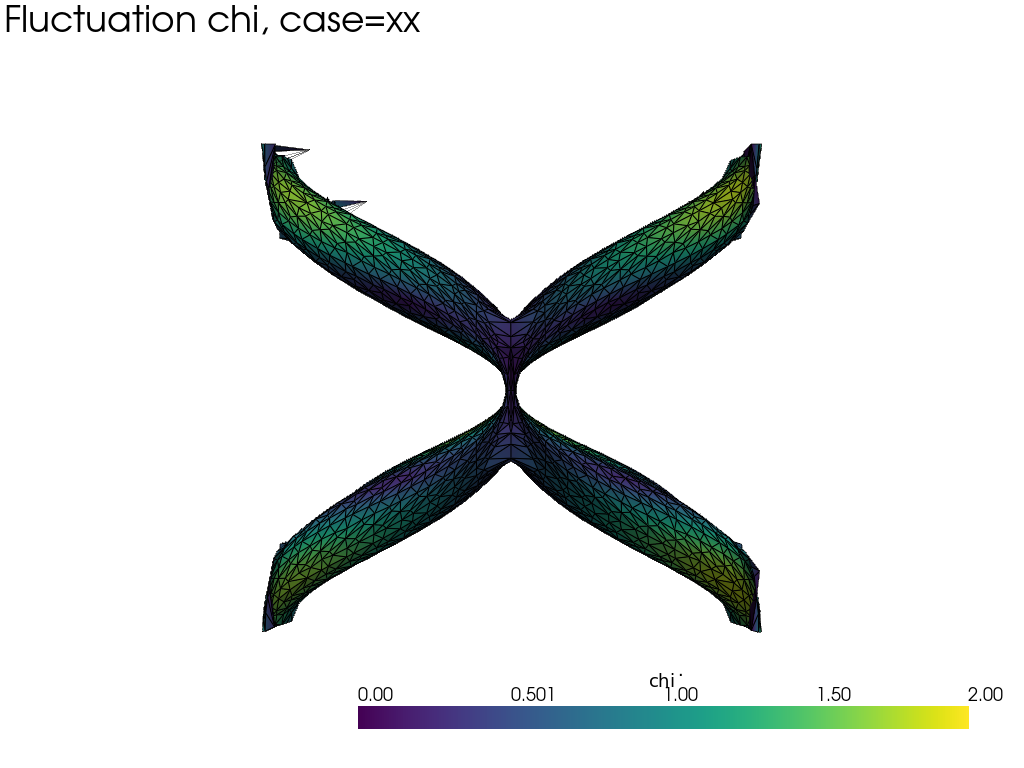

Saved → paraview_out/chi_xx.xdmf


/tmp/ipykernel_87338/2878359798.py:68: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  pl.show()


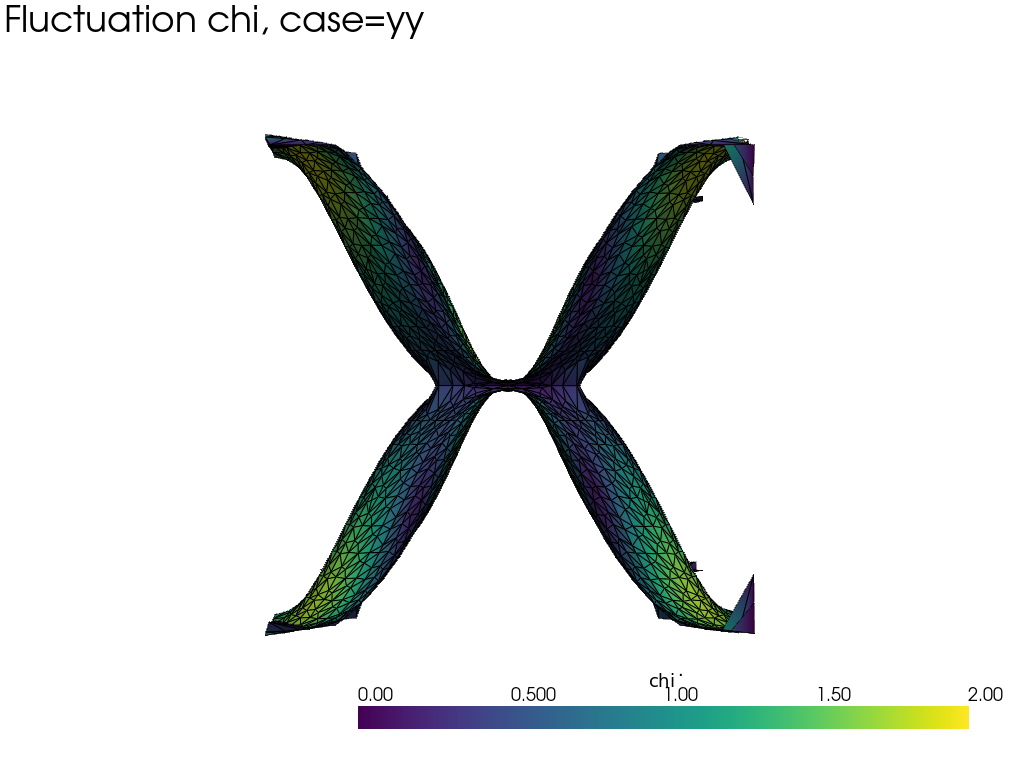

Saved → paraview_out/chi_yy.xdmf


/tmp/ipykernel_87338/2878359798.py:68: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  pl.show()


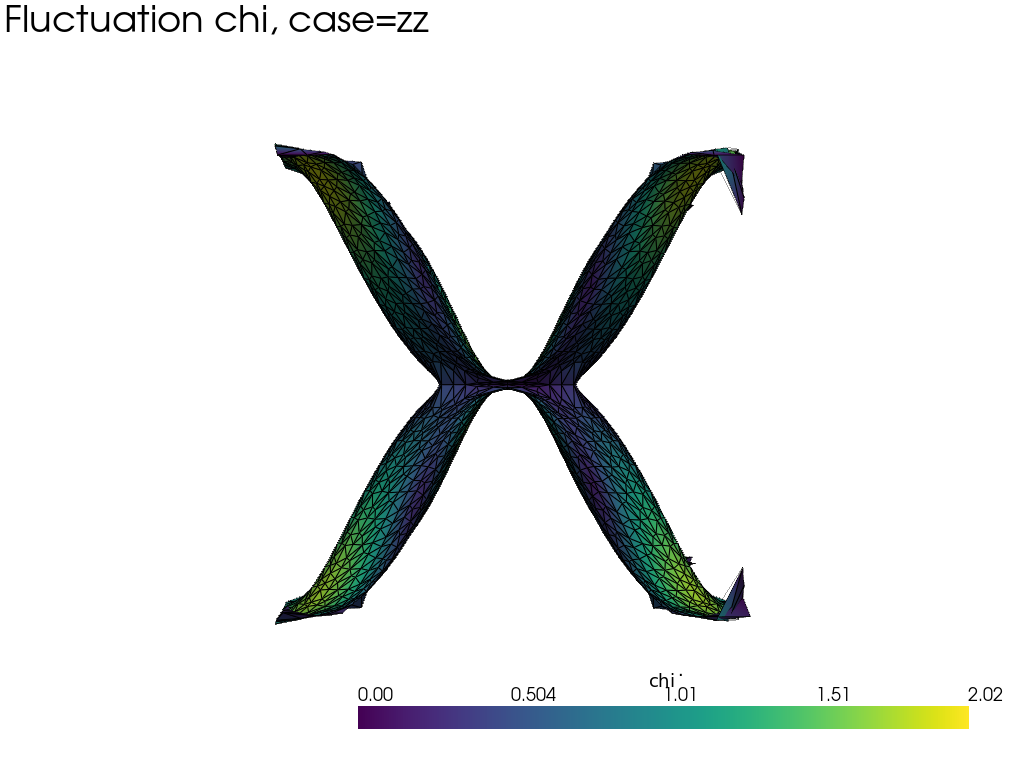

Saved → paraview_out/chi_zz.xdmf


/tmp/ipykernel_87338/2878359798.py:68: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  pl.show()


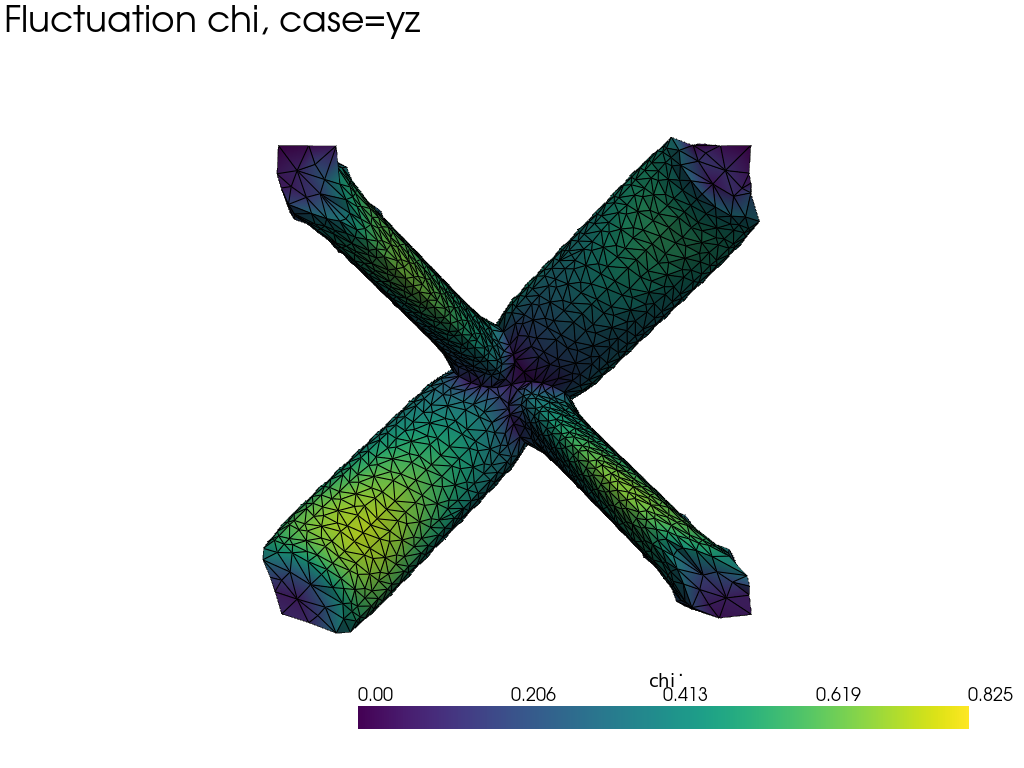

Saved → paraview_out/chi_yz.xdmf


/tmp/ipykernel_87338/2878359798.py:68: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  pl.show()


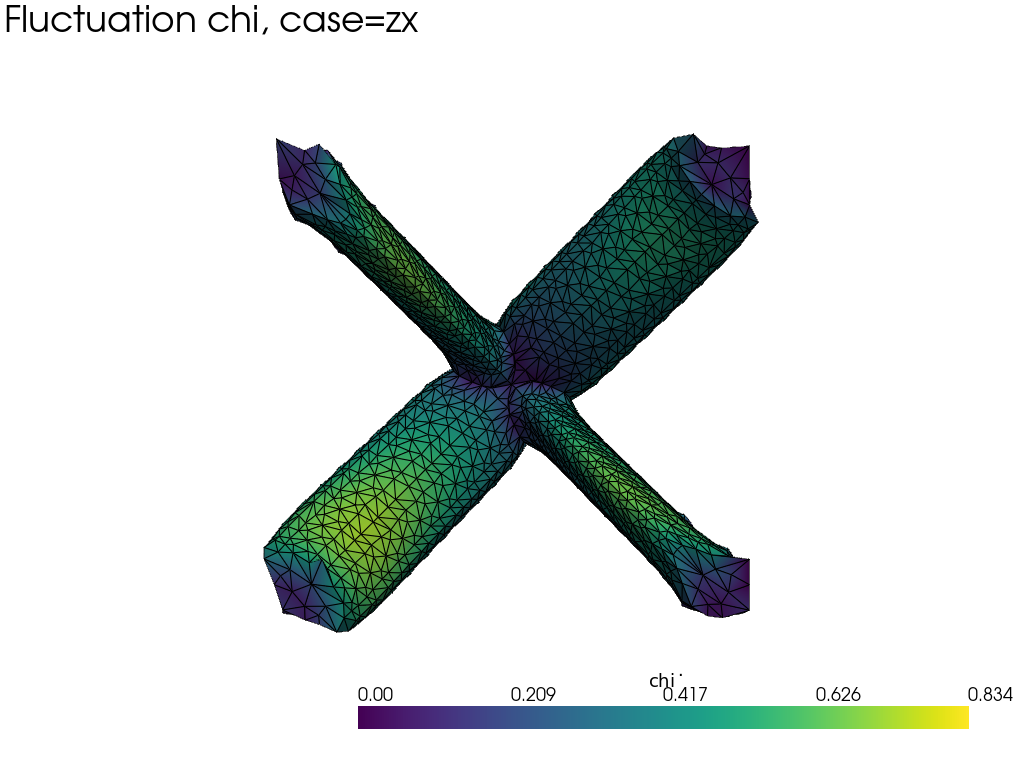

Saved → paraview_out/chi_zx.xdmf


/tmp/ipykernel_87338/2878359798.py:68: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  pl.show()


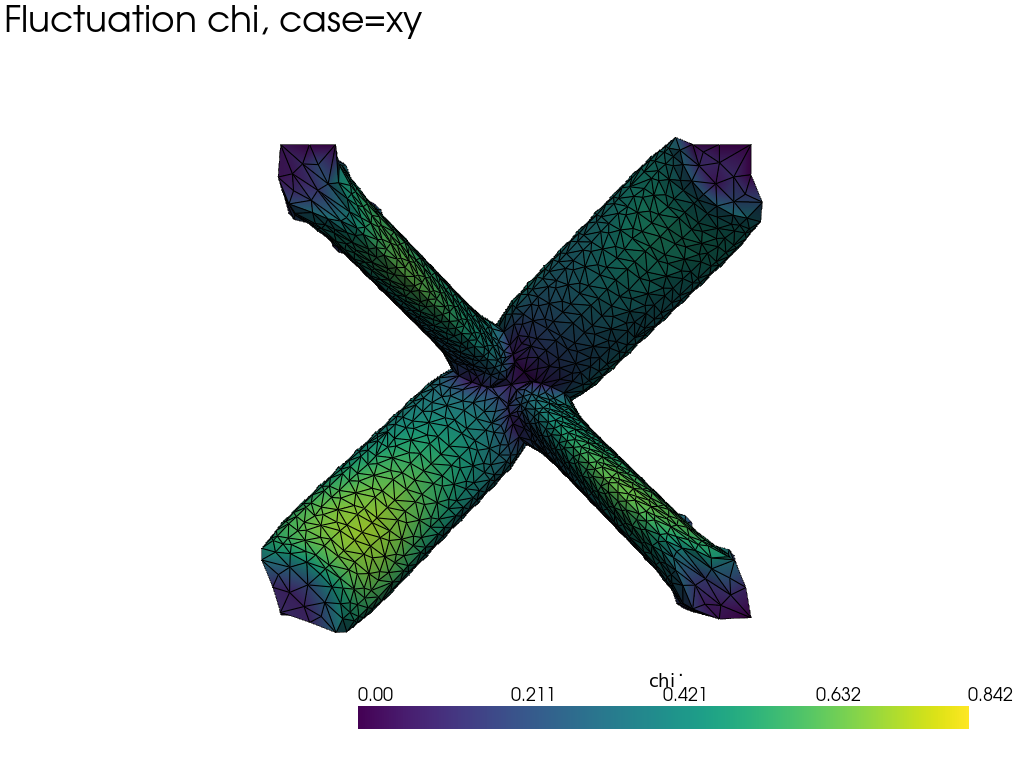

Saved → paraview_out/chi_xy.xdmf


In [110]:
# Eps는 weak form 안에서 참조되고 있어야 함
# 예: Eps = fem.Constant(mesh, np.zeros((3,3)))

u = fem.Function(mpc.function_space, name="chi")  # fluctuation solution container

for case in load_cases:
    # 1) Eps 값 업데이트
    Eps.value[:] = make_Eps_case(case)

    # 2) (선택) 이전 해 잔재 제거
    u.x.array[:] = 0.0

    # 3) problem 생성 + solve (RHS 재조립 확실)
    problem = LinearProblem(
        a_form,
        L_form,
        mpc,
        bcs=bcs,
        u=u,
        petsc_options={"ksp_type": "preonly", "pc_type": "lu"},
    )
    problem.solve()

    # 4) fluctuation field만 플롯
    # plot_fluctuation(u, scale=0.5, title=f"Fluctuation chi, case={case}")
    plot_chi_case(u, case_name=case, scale=1, plot_mesh=True)

    # chi = solution (mpc function space에 있는 unknown)
    chi_sol = u  # 네 코드 기준 solution container

    # ⭐ ParaView export
    export_chi_to_paraview(mesh, chi_sol, case)